<a href="https://colab.research.google.com/github/mdinata/PCB/blob/master/clustering/TK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TK2

* MELISSA CHRISTIAN DINATA (melissa.dinata@binus.ac.id)
* STEPHEN ROYANMART PATRICK (stephen.patrick@binus.ac.id)
* FIRDA MAYANTI (firda.mayanti@binus.ac.id)


https://transjakarta.co.id/mulai-17-maret-2020-transjakarta-tambah-jam-operasional-dengan-123-rute/

## Library Import

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

### Prepare the 1st dataset by combining all .csv files into a single dataframe --> ```df_combi```

In [231]:
bulan = ['januari','februari','maret','april','mei','juni','juli','agustus','september','oktober','november','desember']

df_combi = pd.DataFrame()

for i in bulan:
    file = "https://raw.githubusercontent.com/mdinata/simulearn/main/clustering/data-penumpang-bus-transjakarta-{}-2021.csv".format(i)
    df = pd.read_csv(file)
    df_combi = pd.concat([df_combi, df], ignore_index=True)

df_combi['kode_nama_trayek'] = df_combi['kode_trayek'] + " " + df_combi['trayek']
df_combi['kapasitas'] = df_combi.apply(lambda row: 6 if row['jenis'] == 'Mikrotrans' else 15 if row['jenis'] == 'Angkutan Umum Integrasi' else 45 if row['jenis'] == 'BRT' else 0, axis=1)
df_combi.head()

,tahun,bulan,jenis,kode_trayek,trayek,jumlah_penumpang,kode_nama_trayek,kapasitas
0,2021,1,Mikrotrans,JAK.88,Terminal Tanjung Priok - Ancol Barat,1473,JAK.88 Terminal Tanjung Priok - Ancol Barat,6
1,2021,1,Mikrotrans,JAK.85,Bintara - Cipinang Indah,20280,JAK.85 Bintara - Cipinang Indah,6
2,2021,1,Mikrotrans,JAK.84,Terminal Kampung Melayu - Kapin Raya,28779,JAK.84 Terminal Kampung Melayu - Kapin Raya,6
3,2021,1,Mikrotrans,JAK.80,Rawa Buaya - Rawa Kompeni,54998,JAK.80 Rawa Buaya - Rawa Kompeni,6
4,2021,1,Mikrotrans,JAK.77,Tanjung Priok - Jembatan Item,60284,JAK.77 Tanjung Priok - Jembatan Item,6


Output is a dataframe called ```df_combi```. Next load another dataset and create new dataframe ```df_trayek```.

### Prepare the 2nd dataset -->  ```df_trayek```

In [232]:
df_trayek = pd.read_csv('https://raw.githubusercontent.com/mdinata/simulearn/main/clustering/list-trayek.csv')
df_trayek.head()

,kode_nama_trayek,jarak_km,waktu_min,n_stops,n_unit
0,JAK.88 Terminal Tanjung Priok - Ancol Barat,9.6,30,24,16
1,JAK.85 Bintara - Cipinang Indah,11.0,35,27,10
2,JAK.84 Terminal Kampung Melayu - Kapin Raya,7.9,25,20,15
3,JAK.80 Rawa Buaya - Rawa Kompeni,6.6,20,17,10
4,JAK.77 Tanjung Priok - Jembatan Item,12.3,40,27,16


### Add more variables to calculate performance parameters

In [233]:
df_trayek['load factor'] = 0.7
df_trayek['waktu stop'] = 10
df_trayek['cycle time'] = 1.05 *(( df_trayek['waktu_min'] * 2 ) + df_trayek['waktu stop'])
df_trayek['operational time menit'] = (21 - 5) * 60 #start 05:00 stop 22:00
df_trayek['operational time jam'] = df_trayek['operational time menit'] / df_trayek['cycle time']
df_trayek['kecepatan operasional'] = 60 * (df_trayek['jarak_km'] / df_trayek['waktu_min'])
df_trayek['kecepatan komersial'] = 60 * (2 * df_trayek['jarak_km']) / df_trayek['cycle time']

df_trayek.head()

,kode_nama_trayek,jarak_km,waktu_min,n_stops,n_unit,load factor,waktu stop,cycle time,operational time menit,operational time jam,kecepatan operasional,kecepatan komersial
0,JAK.88 Terminal Tanjung Priok - Ancol Barat,9.6,30,24,16,0.7,10,73.5,960,13.061224,19.200000,15.673469
1,JAK.85 Bintara - Cipinang Indah,11.0,35,27,10,0.7,10,84.0,960,11.428571,18.857143,15.714286
2,JAK.84 Terminal Kampung Melayu - Kapin Raya,7.9,25,20,15,0.7,10,63.0,960,15.238095,18.960000,15.047619
3,JAK.80 Rawa Buaya - Rawa Kompeni,6.6,20,17,10,0.7,10,52.5,960,18.285714,19.800000,15.085714
4,JAK.77 Tanjung Priok - Jembatan Item,12.3,40,27,16,0.7,10,94.5,960,10.158730,18.450000,15.619048
...,...,...,...,...,...,...,...,...,...,...,...,...
132,6F Stasiun Manggarai - Ragunan,10.6,55,28,22,0.7,10,126.0,960,7.619048,11.563636,10.095238
133,GR2 Tanah Abang Explorer,13.2,68,36,11,0.7,10,153.3,960,6.262231,11.647059,10.332681
134,GR3 Ragunan - Departemen Pertanian,10.4,54,27,14,0.7,10,123.9,960,7.748184,11.555556,10.072639
135,6Q Dukuh Atas - Casablanca via Epicentrum Raya,11.2,58,30,15,0.7,10,132.3,960,7.256236,11.586207,10.158730


### Merge the 1st and 2nd dataset based column name ```kode_name_trayek```. Data from ```df_trayek``` will be merged to the left (joined with ```df_combi```).

In [234]:
df_merge = pd.merge(df_combi,df_trayek,on='kode_nama_trayek',how='left')
df_merge = df_merge.sort_values(by='bulan')

### The output of the merge is new dataframe called --> ```df_merge```.

### Calculate the Headway Parameter

In [237]:
df_merge['jumlah_penumpang_harian_per_unit'] = df_merge['jumlah_penumpang'] / df_merge['n_unit'] // 30
df_penumpang_max = df_merge.iloc[:,[3,19]].groupby('kode_trayek').max()

df_merge = pd.merge(df_merge,df_penumpang_max,on='kode_trayek',how='left')
df_merge.columns = df_merge.columns.str.replace('jumlah_penumpang_harian_per_unit_x', 'jumlah_penumpang_harian_per_unit_avg')
df_merge.columns = df_merge.columns.str.replace('jumlah_penumpang_harian_per_unit_y', 'jumlah_penumpang_harian_per_unit_max')

df_merge['jumlah penumpang terpadat'] = df_merge['jumlah_penumpang_harian_per_unit_max'] / df_merge['operational time jam']
df_merge['headway'] = 60 * df_merge['kapasitas'] * df_merge['load factor'] / df_merge['jumlah_penumpang_harian_per_unit_max']

df_merge

In [238]:
#Drop Outlier Rows Mikrotrans
mikrotrans = df_merge[df_merge['jenis']=='Mikrotrans']
mikrotrans = mikrotrans.drop(mikrotrans[mikrotrans['headway'] == mikrotrans['headway'].max()].index)

In [239]:
for i, name in enumerate(mikrotrans.columns):
    print(i, name)

0 tahun
1 bulan
2 jenis
3 kode_trayek
4 trayek
5 jumlah_penumpang
6 kode_nama_trayek
7 kapasitas
8 jarak_km
9 waktu_min
10 n_stops
11 n_unit
12 load factor
13 waktu stop
14 cycle time
15 operational time menit
16 operational time jam
17 kecepatan operasional
18 kecepatan komersial
19 jumlah_penumpang_harian_per_unit_avg
20 jumlah_penumpang_harian_per_unit_max
21 jumlah penumpang terpadat
22 headway


Mikrotrans Performance Distribution

<Axes: xlabel='kecepatan komersial', ylabel='Count'>

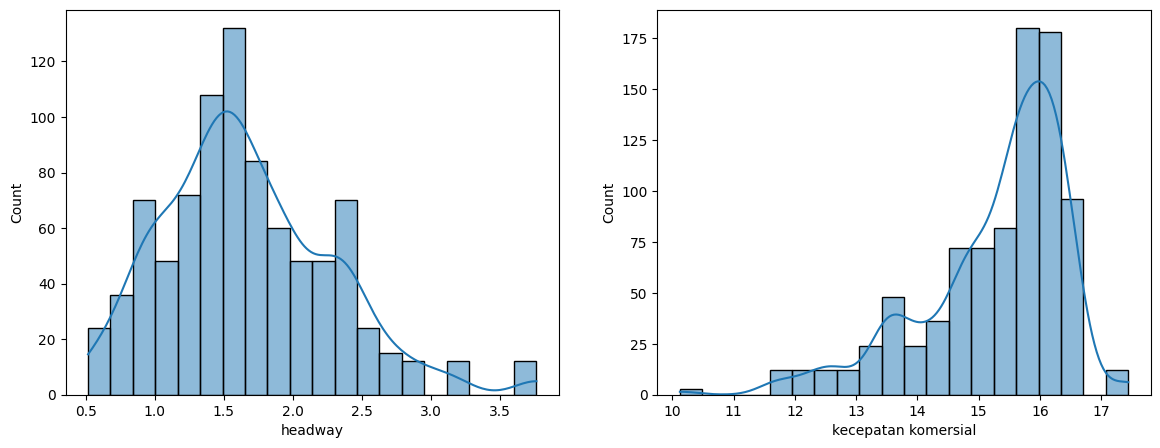

In [240]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
sns.histplot(data=mikrotrans, x='headway', bins=20, kde=True,ax=ax[0])
sns.histplot(data=mikrotrans, x='kecepatan komersial', bins=20, kde=True,ax=ax[1])

K-Means

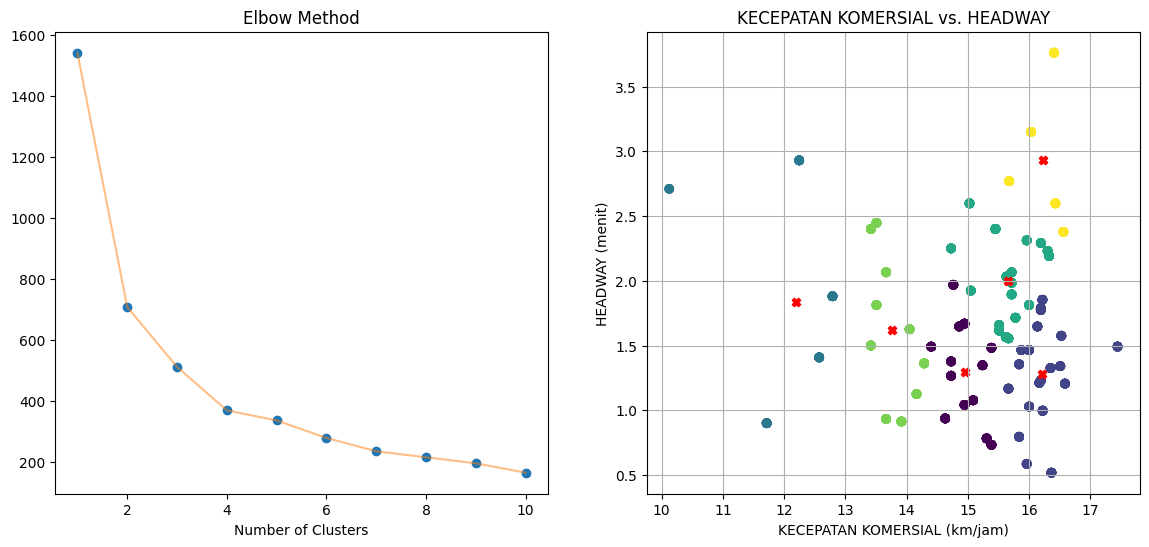

In [276]:
#Determination of K-Value
inertia = []
data = mikrotrans.iloc[:,[18,22]]

data.isna().sum()
data = data.dropna(how='any', axis=0)

for k in range(1 , 11):
    kmeans = (KMeans(n_clusters = k ,init='k-means++', n_init = 1 ,max_iter=300, random_state= 0) )
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(np.arange(1 , 11) , inertia , 'o')
ax[0].plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters') , plt.ylabel('Inertia')

#Clustering
kmeans = KMeans(n_clusters=6)
kmeans.fit(data)
labels = kmeans.predict(data)
centroids = kmeans.cluster_centers_
kmeans_silhouette = silhouette_score(data, labels)

ax[1].scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels)
ax[1].scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red')
ax[1].set_title('{} vs. {}'.format(data.columns[0].upper(),data.columns[1].upper()))
ax[1].set_xlabel('{} (km/jam)'.format(data.columns[0].upper()))
ax[1].set_ylabel('{} (menit)'.format(data.columns[1].upper()))

plt.grid(True)
plt.show()

BRT Performance

In [264]:
brt = df_merge[df_merge['jenis']=='BRT']

<Axes: xlabel='kecepatan komersial', ylabel='Count'>

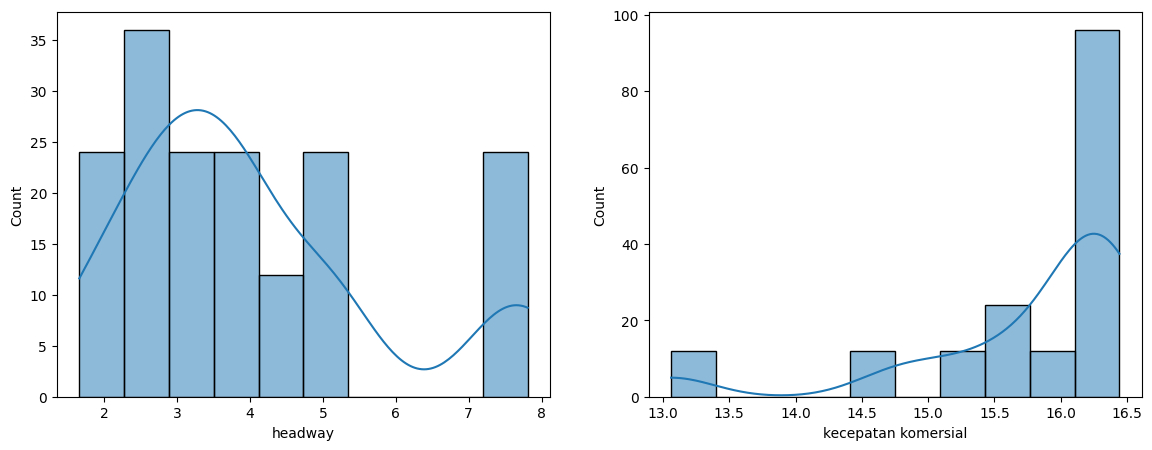

In [267]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
sns.histplot(data=brt, x='headway', bins=10, kde=True,ax=ax[0])
sns.histplot(data=brt, x='kecepatan komersial', bins=10, kde=True,ax=ax[1])

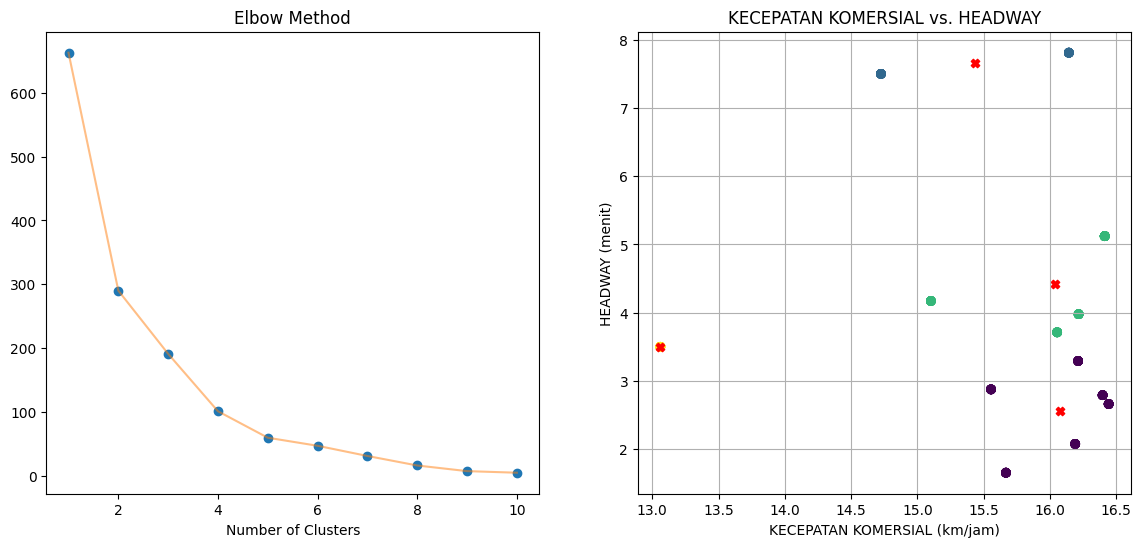

In [268]:
#Determination of K-Value
inertia = []
data = brt.iloc[:,[18,22]]

data.isna().sum()
data = data.dropna(how='any', axis=0)

for k in range(1 , 11):
    kmeans = (KMeans(n_clusters = k ,init='k-means++', n_init = 1 ,max_iter=300, random_state= 0) )
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(np.arange(1 , 11) , inertia , 'o')
ax[0].plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters') , plt.ylabel('Inertia')

#Clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)
labels = kmeans.predict(data)
centroids = kmeans.cluster_centers_
kmeans_silhouette = silhouette_score(data, labels)

ax[1].scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels)
ax[1].scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red')
ax[1].set_title('{} vs. {}'.format(data.columns[0].upper(),data.columns[1].upper()))
ax[1].set_xlabel('{} (km/jam)'.format(data.columns[0].upper()))
ax[1].set_ylabel('{} (menit)'.format(data.columns[1].upper()))

plt.grid(True)
plt.show()

Non-BRT Performance

In [272]:
nonbrt = df_merge[df_merge['jenis']=='Angkutan Umum Integrasi']

<Axes: xlabel='kecepatan komersial', ylabel='Count'>

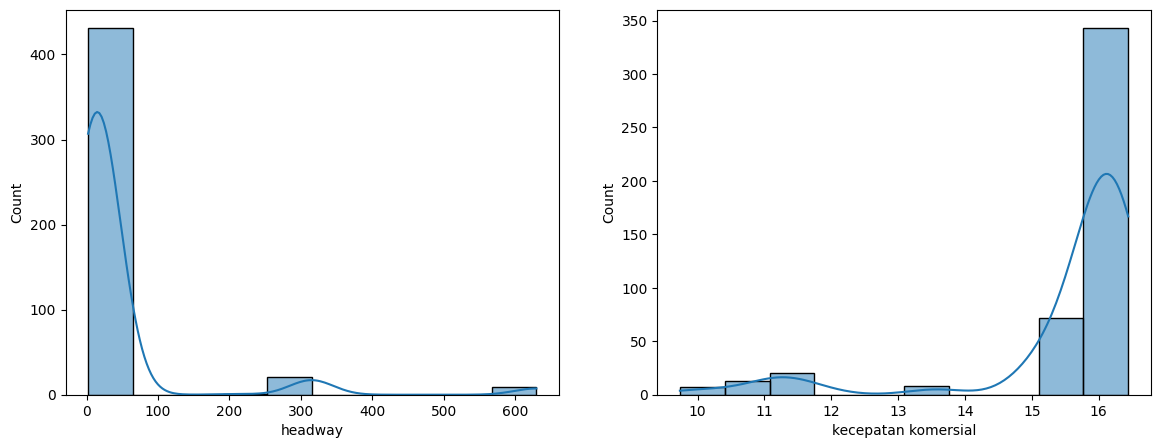

In [273]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
sns.histplot(data=nonbrt, x='headway', bins=10, kde=True,ax=ax[0])
sns.histplot(data=nonbrt, x='kecepatan komersial', bins=10, kde=True,ax=ax[1])

In [315]:
data = nonbrt.iloc[:,[18,22]]
rows_with_inf = data[data.applymap(np.isinf).any(axis=1)]
print(rows_with_inf)

     kecepatan komersial  headway
556            10.095238      inf


In [316]:
data = data.drop(556,axis = 0)

In [317]:
print('before ->', data.shape)

before -> (468, 2)


In [320]:
data = data[data['headway'] < 100]
print('after ->', data.shape)

after -> (431, 2)


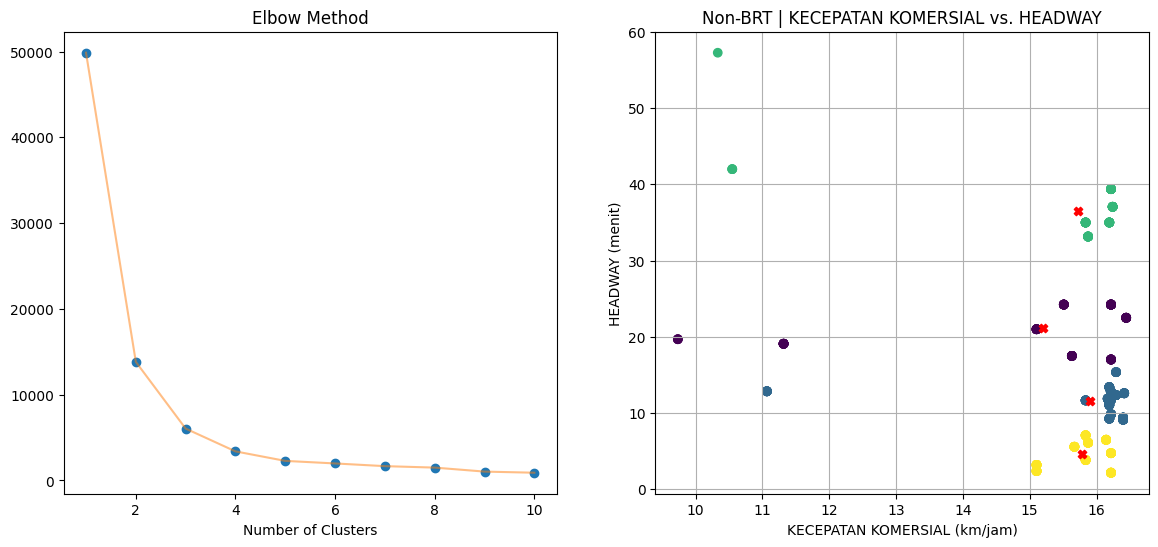

In [325]:
#Determination of K-Value
inertia = []

data.isna().sum()
data = data.dropna(how='any', axis=0)

for k in range(1 , 11):
    kmeans = (KMeans(n_clusters = k ,init='k-means++', n_init = 1 ,max_iter=300, random_state= 0) )
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(np.arange(1 , 11) , inertia , 'o')
ax[0].plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters') , plt.ylabel('Inertia')

#Clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)
labels = kmeans.predict(data)
centroids = kmeans.cluster_centers_
kmeans_silhouette = silhouette_score(data, labels)

ax[1].scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels)
ax[1].scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red')
ax[1].set_title('Non-BRT | {} vs. {}'.format(data.columns[0].upper(),data.columns[1].upper()))
ax[1].set_xlabel('{} (km/jam)'.format(data.columns[0].upper()))
ax[1].set_ylabel('{} (menit)'.format(data.columns[1].upper()))

plt.grid(True)
plt.show()

### Descriptive Analysis of the Dataset

In [336]:
print("Number of columns: {}".format(len(df_merge.columns)))

Number of columns: 23


#### Histogram Distribusi Jumlah Penumpang Group By Jenis Moda Transportasi

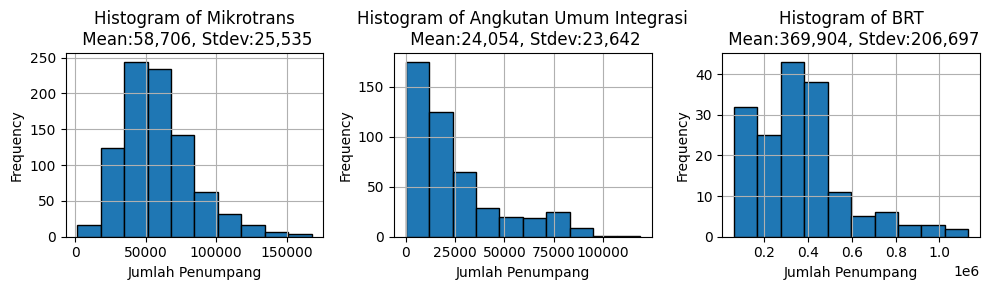

In [338]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

for i, mode in enumerate(df_merge['jenis'].unique()):
    _data = df_merge[(df_merge['jenis'] == mode)]['jumlah_penumpang']
    mean = np.mean(_data)
    std = np.std(_data)
    ax[i].hist(_data,bins=10,edgecolor='black')
    ax[i].set_xlabel("Jumlah Penumpang 2021")
    ax[i].set_ylabel('Frequency')
    ax[i].set_title("Histogram of {}\n Mean:{:,.0f}, Stdev:{:,.0f}".format(mode,mean,std))
    ax[i].grid(True)

plt.tight_layout()
plt.show()

### Boxplot Jumlah Penumpang Group By Jenis Moda Transportasi

Mikrotrans, Median: 55,250
Angkutan Umum Integrasi, Median: 17,270
BRT, Median: 343,265


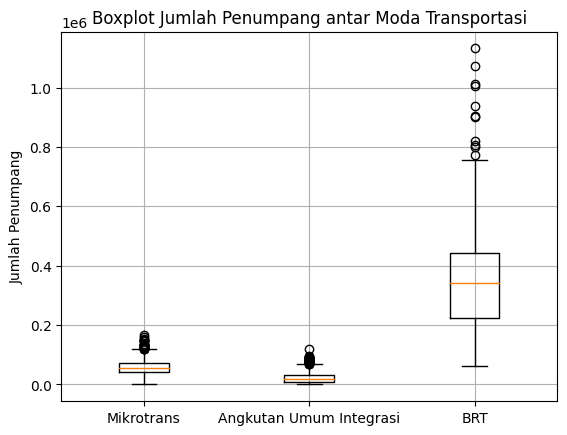

In [335]:
df_boxplot = pd.DataFrame()
boxplot_dict = {}

for i, mode in enumerate(modes):
    _data = df_merge[(df_merge['jenis'] == mode)]['jumlah_penumpang']
    median = np.median(_data)
    print("{}, Median: {:,.0f}".format(mode,median))
    boxplot_dict[mode] = _data.tolist()

values = list(boxplot_dict.values())
plt.boxplot(values)
plt.xticks(range(1, len(boxplot_dict) + 1), boxplot_dict.keys())
plt.ylabel('Jumlah Penumpang')
plt.title("Boxplot Jumlah Penumpang antar Moda Transportasi")
plt.grid(True)
plt.show()